In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg, scipy.integrate
import do
from IPython.display import display, clear_output
from quantum_systems import ODQD, GeneralOrbitalSystem
from matplotlib import animation
%load_ext autoreload
%autoreload 2

In [6]:
### PARAMETERS ###
l = 10 # Number of eigenstates of the HO potential --> we use these functions to generate the single particle WF
grid_length = 10  # The width of the one-dimensional grid
num_grid_points = 201  # The number of discretized points on the grid.
alpha = 1  # The strength of the Coulomb interaction 
a = 0.25  # The shielding parameter in the Coulomb interaction potential
Omega = 0.25  # The frequency of the harmonic oscillator trap
omega = 8*Omega # frequency of the laser field
epsilon0 = 1.0 # amplitude of the laser field
nparticles = 2

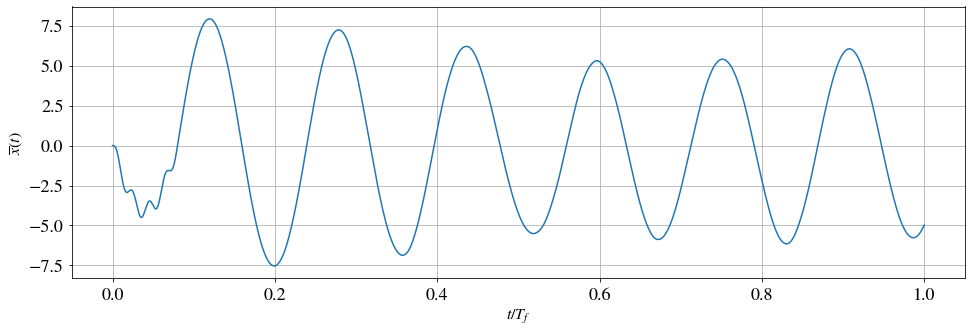

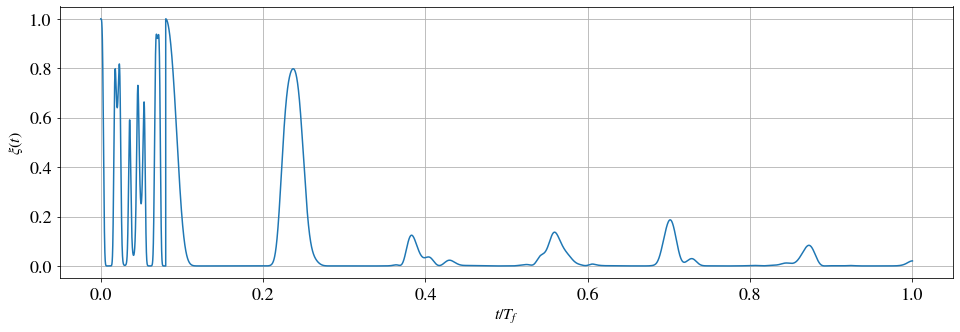

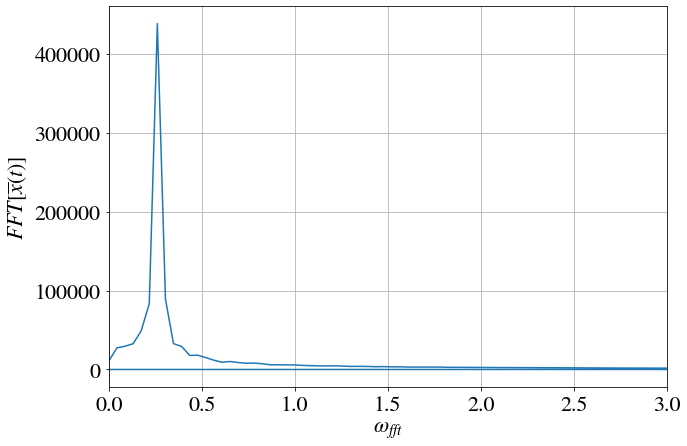

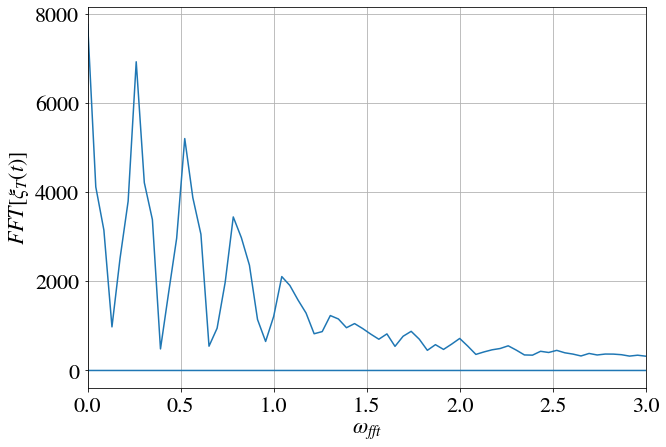

In [128]:
T = np.pi
ghf = do.GHF(omega=omega)
C2, time, dipole, overlap, xFFT, xfreqFFT, overlapFFT, overlapfreqFFT, energy = ghf.fourier_analysis(tolerance=1e-6, max_iter=100, t_laser_ON=4*T, t_max=50*T, dt=1e-3)
ghf.plot_fourier_analysis(time, dipole, overlap, xFFT, xfreqFFT, overlapFFT, overlapfreqFFT)

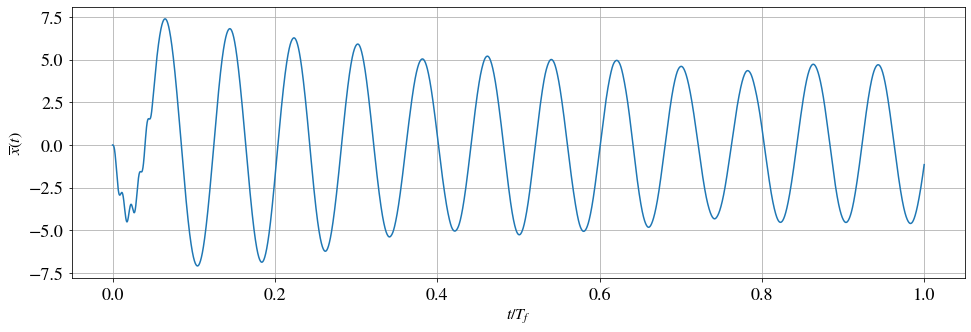

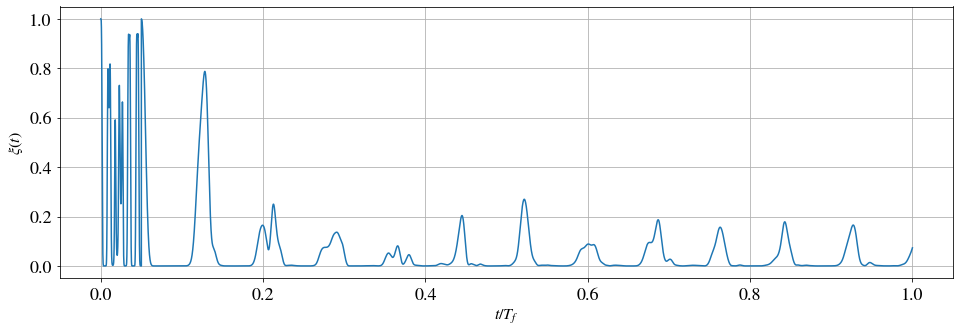

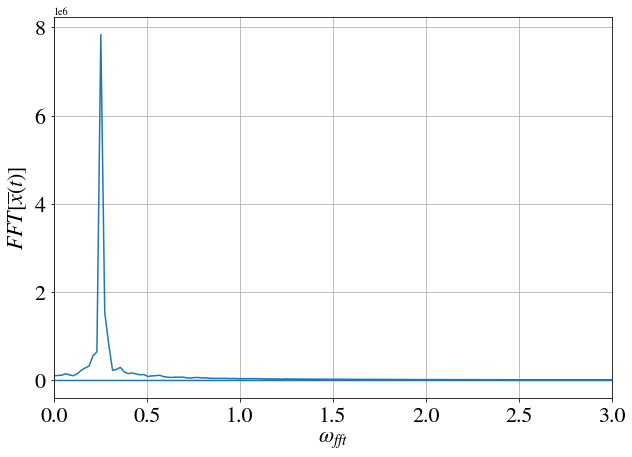

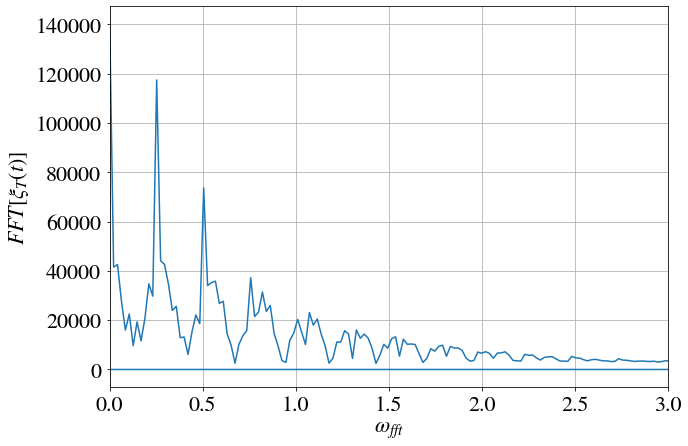

In [132]:
T = np.pi
ghf = do.GHF(omega=omega)
C2, time, dipole, overlap, xFFT, xfreqFFT, overlapFFT, overlapfreqFFT, energy = ghf.fourier_analysis(tolerance=1e-6, max_iter=100, t_laser_ON=5*T, t_max=100*T, dt=1e-4)
ghf.plot_fourier_analysis(time, dipole, overlap, xFFT, xfreqFFT, overlapFFT, overlapfreqFFT)

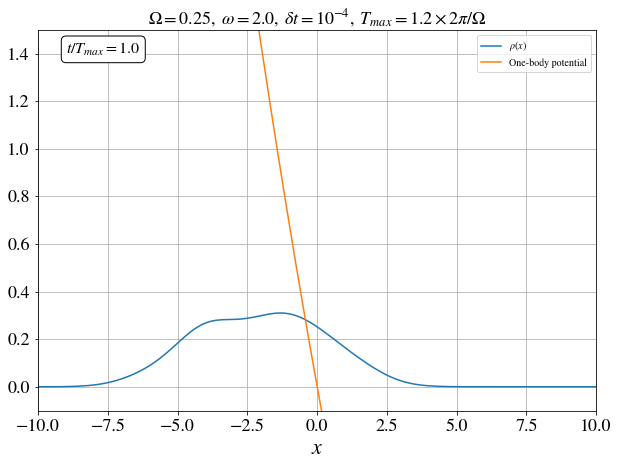

In [158]:
T = 2*np.pi/0.25
ghf = do.GHF(omega=2.0, Omega=0.25)
epsilon, C0, energy_per_step, delta_per_step = ghf.solve_TIHF(tolerance=1e-6, max_iter=100)
ghf.gif_generator(dt=1e-4, t_max=1.2*T, C0=C0, save_every_n=1000)